# Introduction to Visualizing What Convnets Learn
#### Harvard Extension School CS89 Deep Learning
##### Study Notes of Chater 5, Deep Learning with Python

1.Introduction
2.Visualizing intermediate activations
3.Visualizing intermediate activations using CFAIR dataset
4.Visualizng convnet filters
5.Visualizing heatmaps of activations 

In [ ]:
import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## 1. Introduction
***
Deep learning model is like a "black box". Feed data into the inputs, set up the layers then I can somehow get the reasonable output.This is particular true after the development of Tensorflow and Keras. People don't even need to add weights and manually calculate the forwards and backward gradient. Just a couple of lines of code using Keras API, deep learning model can be set up.
***
Visualizing convnets gives a view into how an input is decomposed into different layers by different filters. It is useful to understand how convnet layers transform their input. This project will cover three of the most accessible visualizations:
- Visualize intermediate convnet outputs ("intermediate activations")
- Visualize convnets filters
- Visualize heatmap 

## 2. Visualize Intermediate Activations
***
The output of a layer is often called activation, that is, the output of the activation function. 
<br>
The example below is using the small convnet model trained on the cat vs. dog classifcation problem.

In [58]:
from keras.models import load_model

model = load_model('C:/Users/liche/Desktop/Document/Harvard Extension School/CS 89 Deep Learning/Lecture 6/cats_and_dogs_small_2.h5')
model.summary()  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Us the image of a lion, not part of the network was trained on, to show the example of activation visualization.
***
Note: The dimension of 3D tensor is expanded into 4D to align with the dimension of model input

In [51]:
from keras.preprocessing import image

img_path = 'C:/Users/liche/Desktop/Document/Harvard Extension School/CS 89 Deep Learning/Lecture 7/lion.jpg'

img = image.load_img(img_path, target_size = (150,150))
img_tensor = image.img_to_array(img)
#print(img_tensor)
img_tensor = np.expand_dims(img_tensor, axis =0)

img_tensor /= 255

print(img_tensor.shape)

(1, 150, 150, 3)


Display the orginal lion image

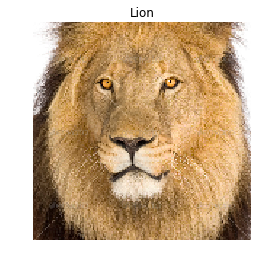

In [53]:
fig, ax = plt.subplots(1,1, figsize = (5,4));
ax.imshow(img_tensor[0])
ax.axis('off')
ax.set_title('Lion')
plt.show()

Use Keras Model Class to visualize different layers of activations.
<br>
In this case, the model has multi-output

In [59]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

Get the output of input tensor

In [60]:
activations = activation_model.predict(img_tensor)

Visualize the first convolution layer of the lion image.
***
There are 32 channels in total. I want to show 1, 3, 30 channels

(1, 148, 148, 32)


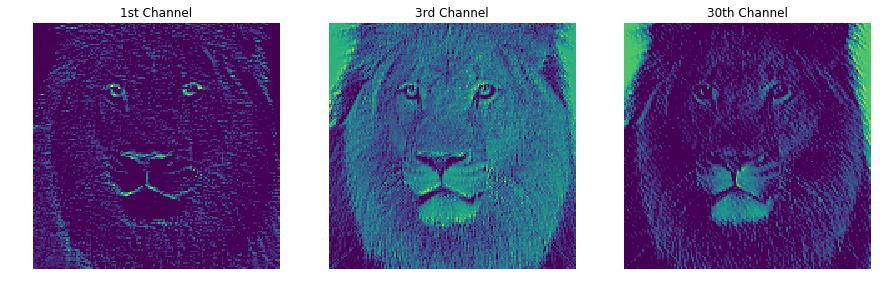

In [67]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

fig, ax = plt.subplots(1,3, figsize = (15,8));
ax[0].imshow(first_layer_activation[0][:,:,1])
ax[0].axis('off')
ax[0].set_title('1st Channel')
ax[1].imshow(first_layer_activation[0][:,:,3])
ax[1].axis('off')
ax[1].set_title('3rd Channel')
ax[2].imshow(first_layer_activation[0][:,:,30])
ax[2].axis('off')
ax[2].set_title('30th Channel')
plt.show()

The first activation seems to encode a diagonal edge detector

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


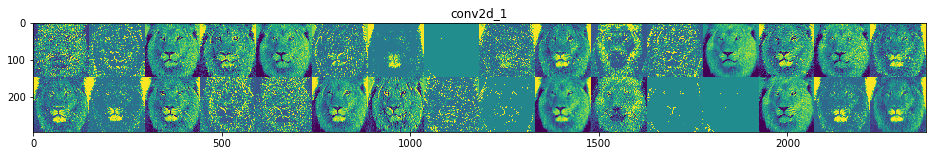

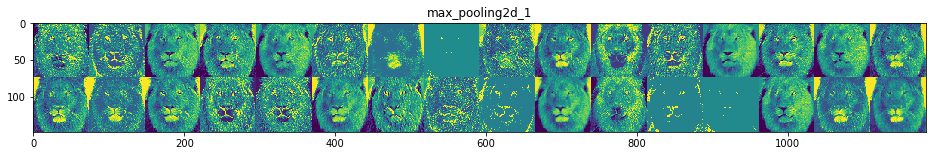

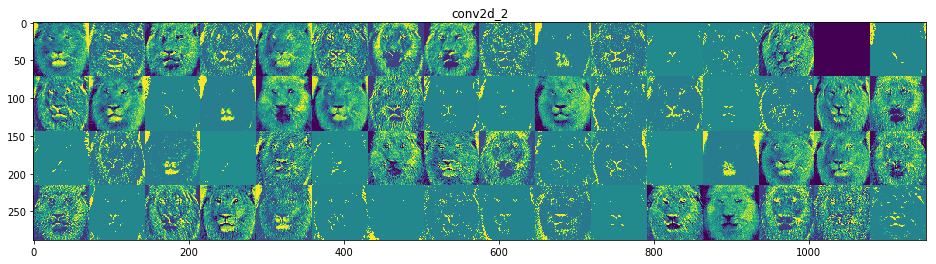

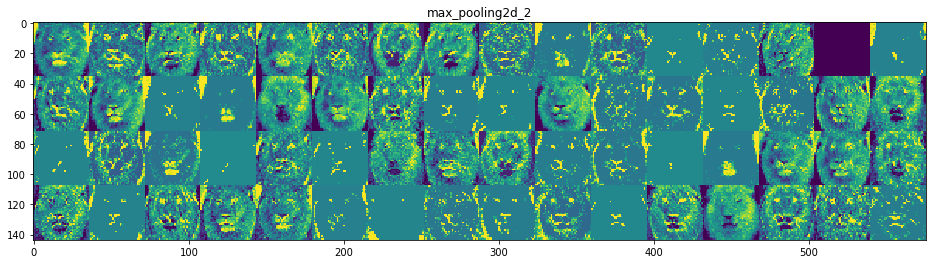

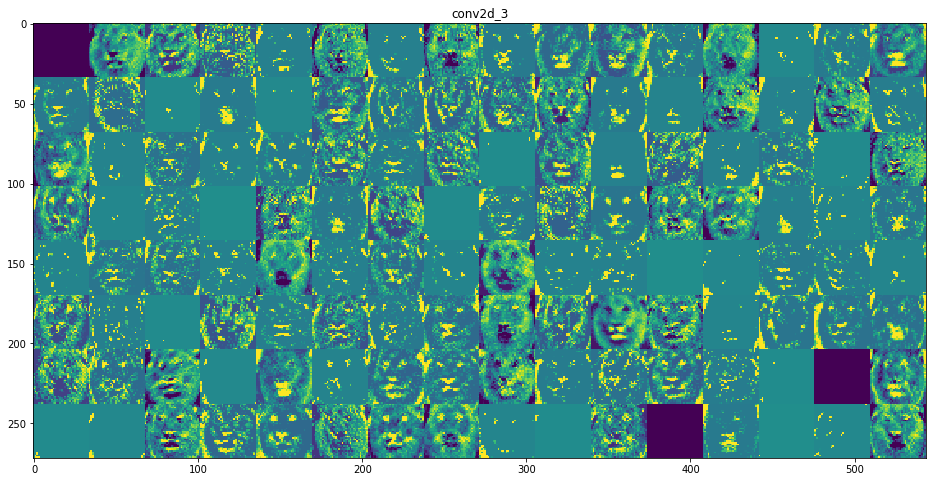

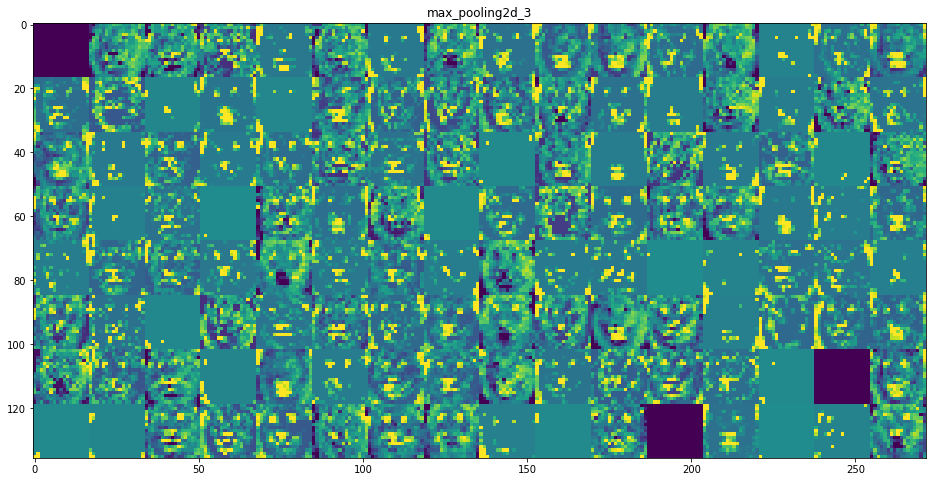

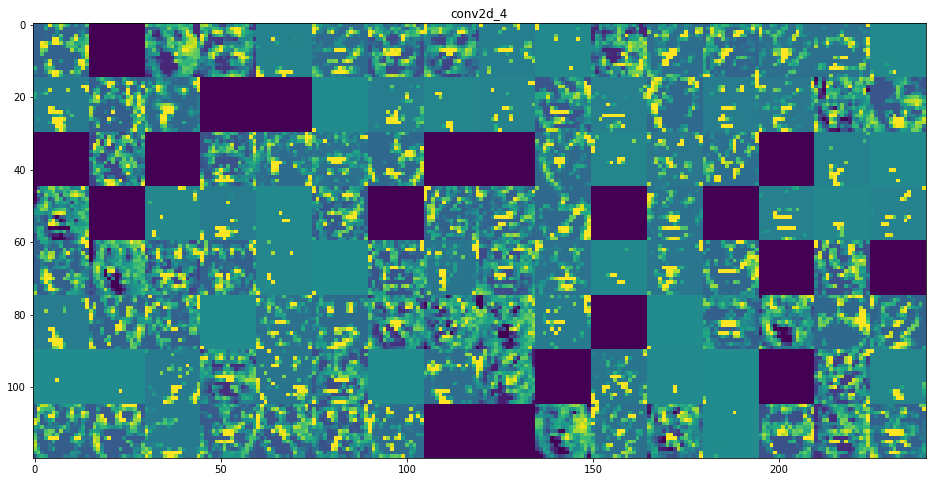

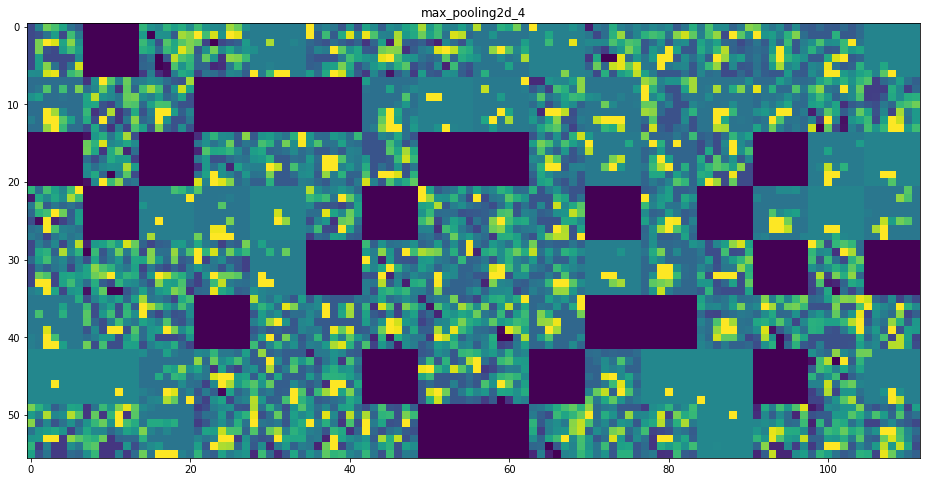

In [9]:
layer_names = []
for layers in model.layers[:8]:
    layer_names.append(layers.name)

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    # tile each filter into the grid
    n_cols = n_features//images_per_row
    
    display_grid = np.zeros((size * n_cols, images_per_row *size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col*images_per_row + row]
            
            ## Normalize the feature to make the visulization appealing 
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            #print(channel_image.shape)
            display_grid[col*size: (col +1) *size, 
                         row*size: (row +1) * size] = channel_image        
           
            #print(display_grid)
    scale = 1./size
    plt.figure(figsize = (scale * display_grid.shape[1],
                         scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

#plt.show()

- Fist layer acts as an edge detector
- Increasingly abstract as move to higher layer
- Sparsity of the activations increases with the depth of the layer

A deep neural network effectively acts as an information distillation pipeline with raw data going in and getting repeatedly transformed so that irrelevant information gets fitered out while useful information get magnified and refined. 


# 3. Visualize Intermediate Activation Using CIFAR Data
*** 
CIFAR10 contains 60,000 images in 10 classes. Those classes are: airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships and large trucks. CIFAR10 is a small subset of CIFAR. 

The following example, I use a random truck image from google to visualize intermediate activation

In [32]:
model_cifar = load_model('C:/Users/liche/Desktop/Document/Harvard Extension School/CS 89 Deep Learning/Lecture 7/cifar.h5')
model_cifar.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        36928     
__________

Show the Truck Image

(32, 32, 3)
(32, 32, 3)
(1, 32, 32, 3)


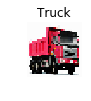

In [33]:
from keras.preprocessing import image

imag_truck_path = 'C:/Users/liche/Desktop/Document/Harvard Extension School/CS 89 Deep Learning/Lecture 7/Truck.jpg'

img_truck = image.load_img(imag_truck_path, target_size = (32,32))
img_truck_tensor = image.img_to_array(img_truck)

print(img_truck_tensor.shape)
#transpose image truck to align with the model_cfair
#img_truck_tensor = np.transpose(img_truck_tensor, (2,1,0))

print(img_truck_tensor.shape)

img_truck_tensor = np.expand_dims(img_truck_tensor, axis =0)

img_truck_tensor /= 255

print(img_truck_tensor.shape)

fig, ax = plt.subplots(1,1, figsize = (3,1));
ax.imshow(img_truck_tensor[0])
ax.axis('off')
ax.set_title('Truck')
plt.show()

Visualize the first convolution layer of the truck image.
***
There are 32 channels in total. I want to show 1, 3, 32 channels

(1, 32, 32, 32)


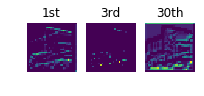

In [34]:
from keras import models

layer_outputs = [layer.output for layer in model_cifar.layers[:12]]
activation_model = models.Model(inputs = model_cifar.input, outputs = layer_outputs)

activations = activation_model.predict(img_truck_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

fig, ax = plt.subplots(1,3, figsize = (3,1));
ax[0].imshow(first_layer_activation[0,:,:,1])
ax[0].axis('off')
ax[0].set_title('1st')
ax[1].imshow(first_layer_activation[0,:,:,3])
ax[1].axis('off')
ax[1].set_title('3rd')
ax[2].imshow(first_layer_activation[0,:,:,30])
ax[2].axis('off')
ax[2].set_title('30th')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


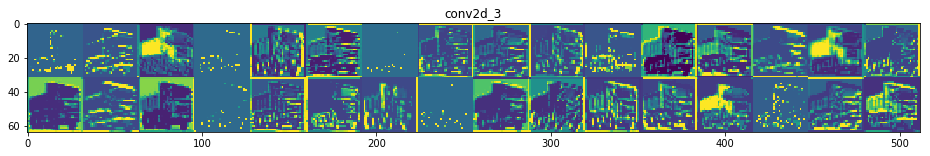

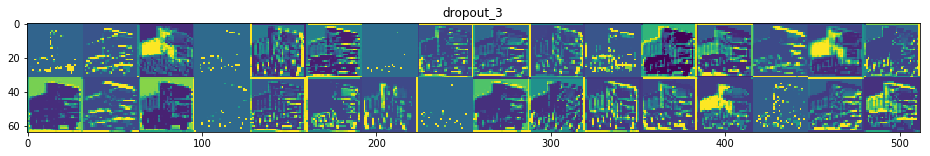

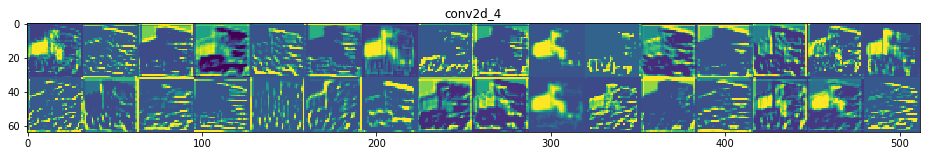

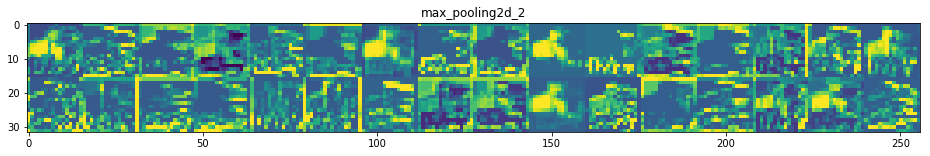

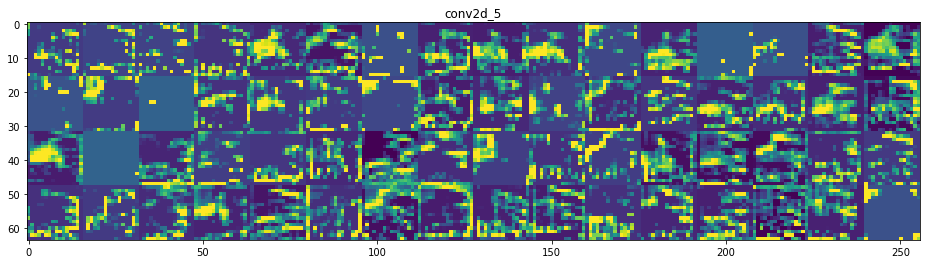

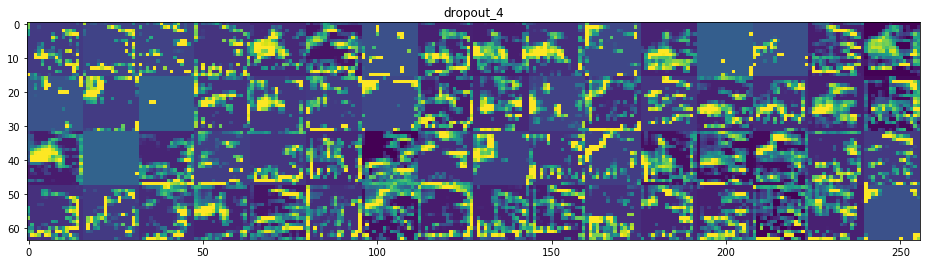

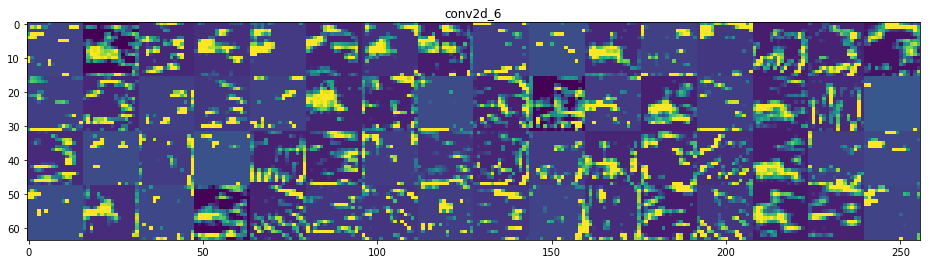

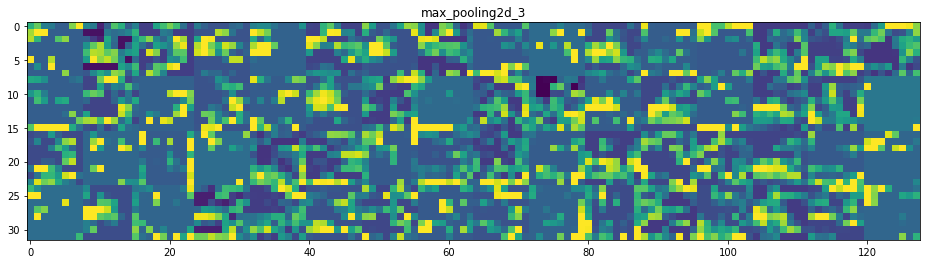

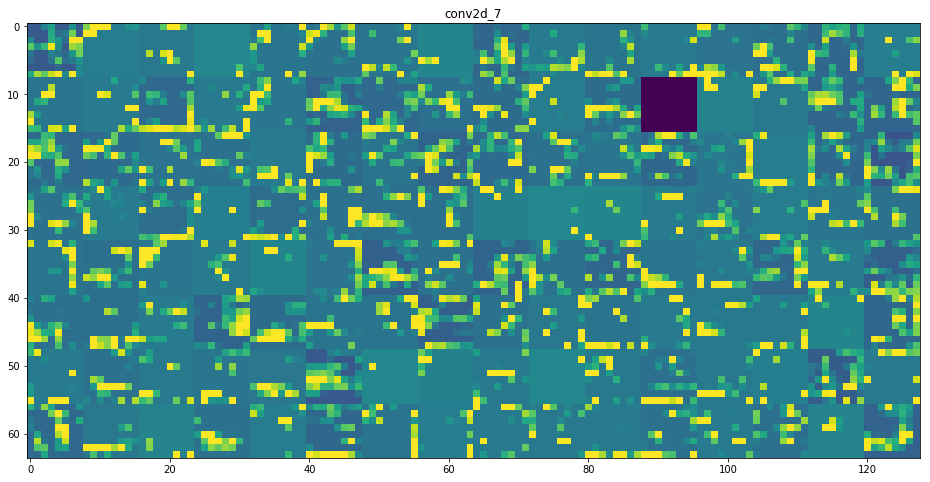

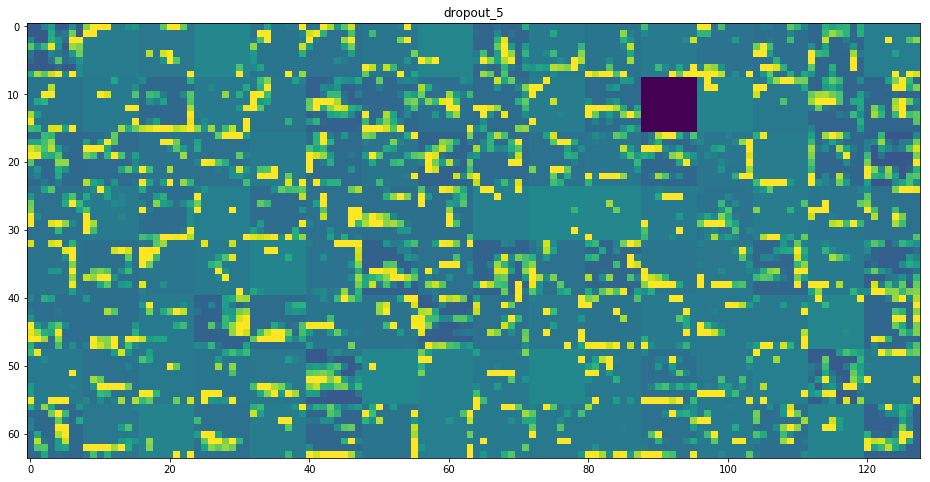

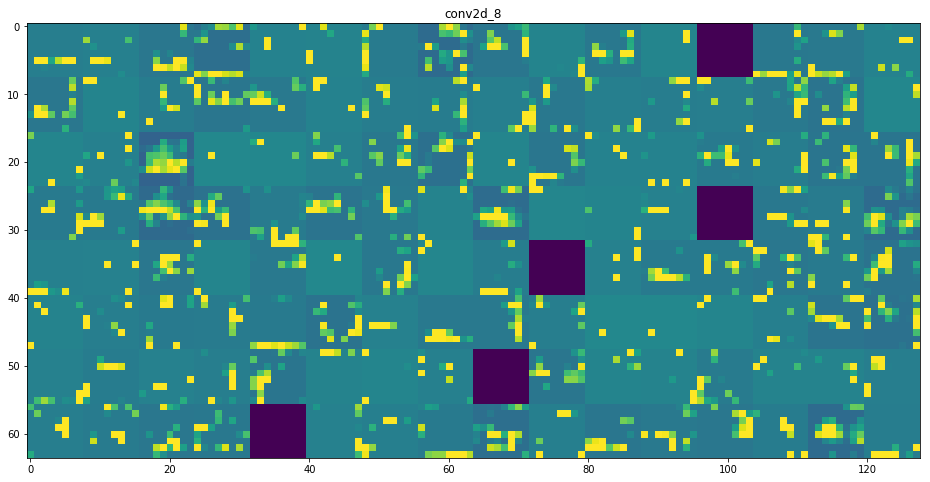

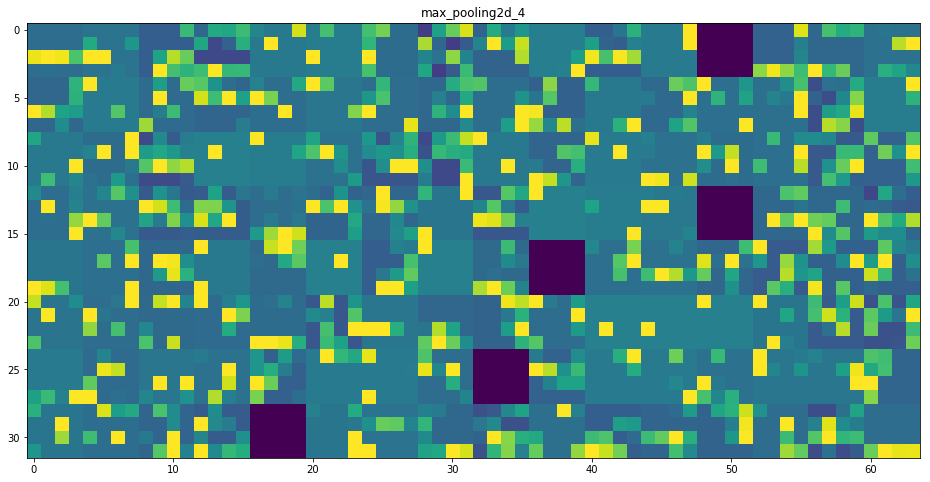

In [13]:
layer_names = []
for layers in model_cifar.layers[:12]:
    layer_names.append(layers.name)

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    # tile each filter into the grid
    n_cols = n_features//images_per_row
    
    display_grid = np.zeros((size * n_cols, images_per_row *size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col*images_per_row + row]
            
            ## Normalize the feature to make the visulization appealing 
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            #print(channel_image.shape)
            display_grid[col*size: (col +1) *size, 
                         row*size: (row +1) * size] = channel_image        
           
            #print(display_grid)
    scale = 1./size
    plt.figure(figsize = (scale * display_grid.shape[1],
                         scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

#plt.show()

# 4. Visualizing convnet filters
*** 
Starting from a blank input image, display the filters learned by convnets.

In [14]:
from keras.applications import VGG16
from keras import backend as K

In [16]:
def generate_pattern(layer_name, filter_index, size=32):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model_cifar.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model_cifar.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model_cifar.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

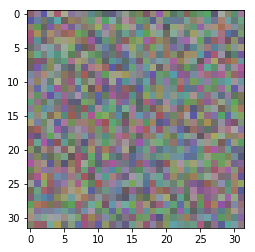

In [17]:
plt.imshow(generate_pattern('conv2d_3', 0))
plt.show()

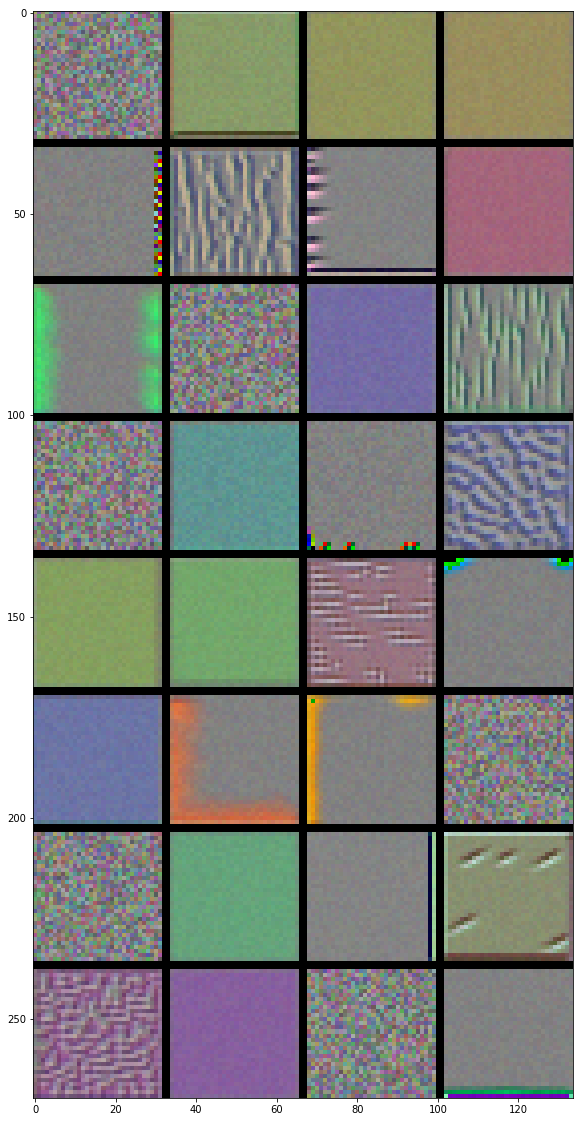

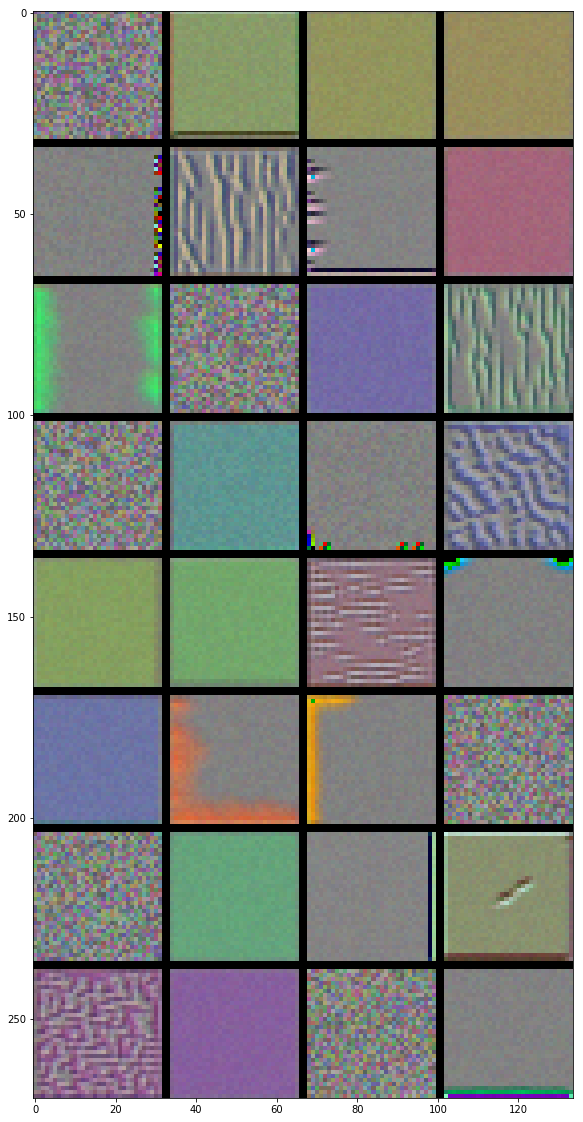

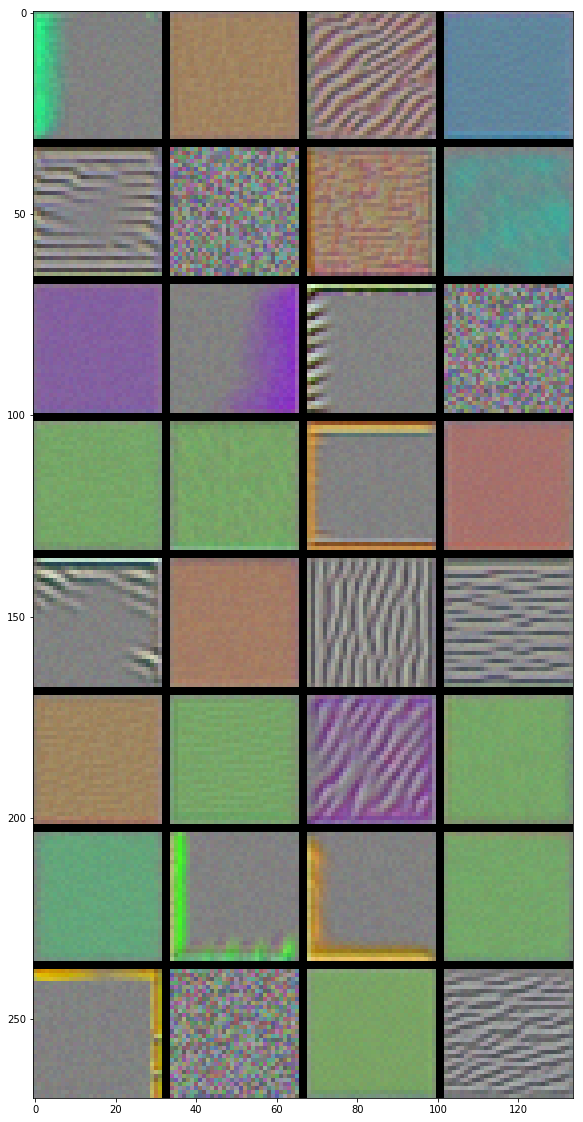

In [18]:
for layer_name in layer_names[:3]:
    size = 32
    margin = 2

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 4 * size + 3 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(4):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

From the filter visualization, we can tell how convnet layers see the world. 

# 5. Visualizing heatmaps of class activation
## Test Birds Headtmap

In [35]:
from keras.applications.vgg16 import VGG16
from keras import backend as K
K.clear_session()

from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

## from keras.preprocessing import image

# The local path to our target image
img_path = 'C:/Users/liche/Desktop/Document/Harvard Extension School/CS 89 Deep Learning/Lecture 7/birds.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)           

In [36]:
preds = model.predict(x)
print(x.shape)
print('Predicted:', decode_predictions(preds, top=3)[0])
np.argmax(preds[0])

(1, 224, 224, 3)
Predicted: [('n01608432', 'kite', 0.7952369), ('n01616318', 'vulture', 0.06981363), ('n01828970', 'bee_eater', 0.032259997)]


21

In [37]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 21]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

print(grads.shape)
# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

(?, 14, 14, 512)


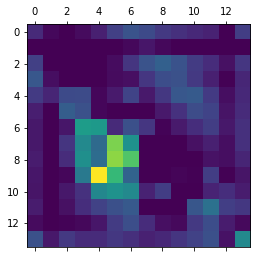

In [38]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [41]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('C:/Users/liche/Desktop/Document/Harvard Extension School/CS 89 Deep Learning/Lecture 7/birds_cam.jpg', superimposed_img)

True

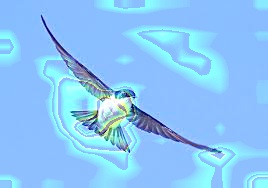

### Use Truck and Test CIFAR Model

In [19]:
truck_output = model_cifar.predict(img_truck_tensor)

np.argmax(truck_output[0])


9

In [20]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model_cifar.output[:, 9]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_cifar.get_layer('conv2d_3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

print(pooled_grads)
# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model_cifar.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_truck_tensor])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(32):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

#print(conv_layer_
# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)
#print(heatmap)

Tensor("Mean_194:0", shape=(32,), dtype=float32)


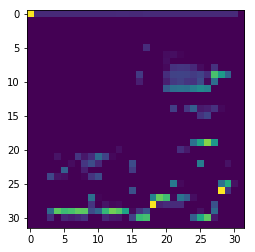

In [21]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)
plt.show()

In [23]:
import cv2
import numpy as np

# We use cv2 to load the original image
img_truck = cv2.imread(imag_truck_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img_truck.shape[1], img_truck.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img_truck

#superimposed_img=superimposed_img.astype(np.float32)

# Save the image to disk
cv2.imwrite('C:/Users/liche/Desktop/Document/Harvard Extension School/CS 89 Deep Learning/Lecture 7/elephant_cam.jpg', superimposed_img)

True

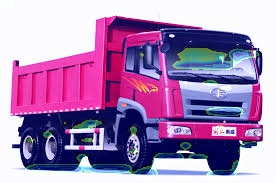